# Setup
(No need to change anything)

In [1]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-nnypmaz4
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-nnypmaz4
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit ce82675a8e89b6d5e6229a89620c843c794f3b04
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.5 MB/s eta 0:00:00
    

In [2]:
# # Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
# import plotly.io as pio

# if IN_COLAB or not DEBUG_MODE:
#     # Thanks to annoying rendering issues, Plotly graphics will either show up in colab OR Vscode depending on the renderer - this is bad for developing demos! Thus creating a debug mode.
#     pio.renderers.default = "colab"
# else:
#     pio.renderers.default = "png"

In [3]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [4]:
# import pysvelte

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [5]:
torch.set_grad_enabled(False)

Plotting helper functions:

In [6]:
# def imshow(tensor, renderer=None, **kwargs):
#     px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

# def line(tensor, renderer=None, **kwargs):
#     px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

# def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
#     x = utils.to_numpy(x)
#     y = utils.to_numpy(y)
#     px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

## Load Model

In [7]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


## Import functions from repo

In [8]:
!git clone https://github.com/callummcdougall/ARENA_2.0.git

Cloning into 'ARENA_2.0'...
remote: Enumerating objects: 9262, done.
remote: Counting objects: 100% (1976/1976), done.
remote: Compressing objects: 100% (344/344), done.
remote: Total 9262 (delta 1727), reused 1731 (delta 1628), pack-reused 7286
Receiving objects: 100% (9262/9262), 156.79 MiB | 16.11 MiB/s, done.
Resolving deltas: 100% (5620/5620), done.


In [9]:
cd ARENA_2.0/chapter1_transformers/exercises/part3_indirect_object_identification

/content/ARENA_2.0/chapter1_transformers/exercises/part3_indirect_object_identification


In [10]:
import ioi_circuit_extraction as ioi_circuit_extraction

In [11]:
1

1

# Generate dataset with multiple prompts

In [12]:
class Dataset:
    def __init__(self, prompts, pos_dict, tokenizer, S1_is_first=False):
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.prompts
            ]
        )
        # all_ids = [prompt["TEMPLATE_IDX"] for prompt in self.ioi_prompts]
        all_ids = [0 for prompt in self.prompts] # only 1 template
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        texts = [ prompt["text"] for prompt in self.prompts ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )
        self.corr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["corr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["corr"])[0] for prompt in self.prompts
        ]
        self.incorr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["incorr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["incorr"])[0] for prompt in self.prompts
        ]

        # word_idx: for every prompt, find the token index of each target token and "end"
        # word_idx is a tensor with an element for each prompt. The element is the targ token's ind at that prompt
        self.word_idx = {}
        # for targ in [key for key in self.prompts[0].keys() if (key != 'text' and key != 'corr' and key != 'incorr')]:
        for targ in [key for key in pos_dict]:
            targ_lst = []
            for prompt in self.prompts:
                input_text = prompt["text"]
                tokens = model.tokenizer.tokenize(input_text)
                # if S1_is_first and targ == "S1":  # only use this if first token doesn't have space Ġ in front
                #     target_token = prompt[targ]
                # else:
                #     target_token = "Ġ" + prompt[targ]
                # target_index = tokens.index(target_token)
                target_index = pos_dict[targ]
                targ_lst.append(target_index)
            self.word_idx[targ] = torch.tensor(targ_lst)

        targ_lst = []
        for prompt in self.prompts:
            input_text = prompt["text"]
            tokens = self.tokenizer.tokenize(input_text)
            end_token_index = len(tokens) - 1
            targ_lst.append(end_token_index)
        self.word_idx["end"] = torch.tensor(targ_lst)

    def __len__(self):
        return self.N

In [13]:
import pickle

prompts_list = []

temps = ['done', 'lost', 'names']  #

for i in temps:
    file_name = f'/content/nw_prompts_{i}.pkl'
    with open(file_name, 'rb') as file:
        filelist = pickle.load(file)

    print(filelist[0]['text'])
    prompts_list += filelist [:512] #768 512

len(prompts_list)

Van done in one. Hat done in two. Ring done in three. Desk done in four. Sun done in
Oil lost in one. Apple lost in two. Tree lost in three. Snow lost in four. Apple lost in
Marcus born in one. Victoria born in two. George born in three. Brandon born in four. Jamie born in


1536

In [14]:
# pos_dict = {
#     'S1': 4,
#     'S2': 10,
#     'S3': 16,
#     'S4': 22,
# }

pos_dict = {}
for i in range(len(model.tokenizer.tokenize(prompts_list[0]['text']))):
    pos_dict['S'+str(i)] = i

# pos_dict

In [15]:
dataset = Dataset(prompts_list, pos_dict, model.tokenizer, S1_is_first=True)

In [16]:
# import random

# def generate_prompts_list_corr(prompt_list):
#     outlist = []
#     for prompt_dict in prompts_list:
#         months = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve']
#         r1 = random.choice(months)
#         r2 = random.choice(months)
#         while True:
#             r3_ind = random.randint(0,len(months)-1)
#             r4_ind = random.randint(0,len(months)-1)
#             if months[r3_ind] != months[r4_ind-1]:
#                 break
#         r3 = months[r3_ind]
#         r4 = months[r4_ind]

#         new_text = prompt_dict['text'].replace("done", 'zzz')
#         new_text = new_text.replace(prompt_dict['S1'], str(r1)).replace(prompt_dict['S2'], str(r2)).replace(prompt_dict['S3'], str(r3)).replace(prompt_dict['S4'], str(r4))
#         new_text = new_text.replace("zzz", 'done')
#         new_prompt_dict = {
#             'S1': str(r1),
#             'S2': str(r2),
#             'S3': str(r3),
#             'S4': str(r4),
#             'corr': prompt_dict['corr'],
#             'incorr': prompt_dict['incorr'],
#             'text': new_text
#         }
#         outlist.append(new_prompt_dict)
#     return outlist
# prompts_list_2 = generate_prompts_list_corr(prompts_list)

In [18]:
import pickle
task = "numwords"
file_name = f'/content/randDS_{task}.pkl'
with open(file_name, 'rb') as file:
    prompts_list_2 = pickle.load(file)

In [19]:
prompts_list_2[:10]

[{'S1': 'two',
  'S2': 'two',
  'S3': 'twelve',
  'S4': 'ten',
  'corr': ' five',
  'incorr': ' four',
  'text': 'Van done in two. Hat done in two. Ring done in twelve. Desk done in ten. Sun done in'},
 {'S1': 'eight',
  'S2': 'six',
  'S3': 'eight',
  'S4': 'five',
  'corr': ' six',
  'incorr': ' five',
  'text': 'Ice done in eight. Snow done in six. Watch done in eight. Sun done in five. Table done in'},
 {'S1': 'ten',
  'S2': 'eleven',
  'S3': 'two',
  'S4': 'nine',
  'corr': ' seven',
  'incorr': ' six',
  'text': 'Ring done in ten. Moon done in eleven. Queen done in two. Book done in nine. Rose done in'},
 {'S1': 'one',
  'S2': 'three',
  'S3': 'two',
  'S4': 'four',
  'corr': ' eight',
  'incorr': ' seven',
  'text': 'Queen done in one. Oil done in three. Rose done in two. Desk done in four. Car done in'},
 {'S1': 'two',
  'S2': 'eleven',
  'S3': 'one',
  'S4': 'twelve',
  'corr': ' nine',
  'incorr': ' eight',
  'text': 'Light done in two. Arm done in eleven. Road done in one. B

In [20]:
# import pickle
# from google.colab import files

# with open('randDS_numwords.pkl', 'wb') as file:
#     pickle.dump(prompts_list_2, file)
# files.download('randDS_numwords.pkl')

In [21]:
len(prompts_list_2)

1536

In [22]:
dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer, S1_is_first=True)

# get orig score

In [23]:
from torch import Tensor

def logits_to_ave_logit_diff_2(logits: Float[Tensor, "batch seq d_vocab"], dataset: Dataset, per_prompt=False):
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''

    # Only the final logits are relevant for the answer
    # Get the logits corresponding to the indirect object / subject tokens respectively
    corr_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset.word_idx["end"], dataset.corr_tokenIDs]
    incorr_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset.word_idx["end"], dataset.incorr_tokenIDs]
    # Find logit difference
    answer_logit_diff = corr_logits - incorr_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()

In [24]:
model.reset_hooks(including_permanent=True)
# ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)
ioi_logits_original = model(dataset.toks)
orig_score = logits_to_ave_logit_diff_2(ioi_logits_original, dataset)

In [25]:
import gc

# del(ioi_cache)
del(ioi_logits_original)

torch.cuda.empty_cache()
gc.collect()

18

# Ablation Expm Functions

In [ ]:
def mean_ablate_by_lst(lst, model, orig_score, print_output=True):
    # CIRCUIT = {
    #     "number mover": lst,
    #     "number mover 4": lst,
    #     "number mover 3": lst,
    #     "number mover 2": lst,
    #     "number mover 1": lst,
    # }

    # SEQ_POS_TO_KEEP = {
    #     "number mover": "end",
    #     "number mover 4": "S4",
    #     "number mover 3": "S3",
    #     "number mover 2": "S2",
    #     "number mover 1": "S1",
    # }
    CIRCUIT = {}
    SEQ_POS_TO_KEEP = {}
    for i in range(len(model.tokenizer.tokenize(prompts_list_2[0]['text']))):
        CIRCUIT['S'+str(i)] = lst
        if i == len(model.tokenizer.tokenize(prompts_list_2[0]['text'])) - 1:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
        else:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)

    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    # ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

    model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    ioi_logits_minimal = model(dataset.toks)

    # orig_score = logits_to_ave_logit_diff_2(ioi_logits_original, dataset)
    new_score = logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset)
    # del(ioi_logits_minimal)
    if print_output:
        # print(f"Average logit difference (IOI dataset, using entire model): {orig_score:.4f}")
        # print(f"Average logit difference (IOI dataset, only using circuit): {new_score:.4f}")
        print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
    # return new_score
    return 100 * new_score / orig_score

# rmv most impt heads from full

In [ ]:
circ = [(layer, head) for layer in range(12) for head in range(12)]
to_loop = [(layer, head) for layer in range(12) for head in range(12)]
#  [(7, 11), (4, 4), (1, 5), (10, 7), (8, 8), (8, 6), (9, 1), (6, 6), (8, 1), (6, 10)]

lh_scores = {}
# for lh in circ:
for lh in to_loop:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = mean_ablate_by_lst(copy_circuit, model, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

removed: (0, 0)
Average logit difference (circuit / full) %: 100.9832
removed: (0, 1)
Average logit difference (circuit / full) %: 8.1006
removed: (0, 2)
Average logit difference (circuit / full) %: 100.4444
removed: (0, 3)
Average logit difference (circuit / full) %: 100.1392
removed: (0, 4)
Average logit difference (circuit / full) %: 102.1836
removed: (0, 5)
Average logit difference (circuit / full) %: 94.9820
removed: (0, 6)
Average logit difference (circuit / full) %: 103.1773
removed: (0, 7)
Average logit difference (circuit / full) %: 101.7027
removed: (0, 8)
Average logit difference (circuit / full) %: 100.7235
removed: (0, 9)
Average logit difference (circuit / full) %: 98.2363
removed: (0, 10)
Average logit difference (circuit / full) %: 104.2154
removed: (0, 11)
Average logit difference (circuit / full) %: 99.9846
removed: (1, 0)
Average logit difference (circuit / full) %: 102.1491
removed: (1, 1)
Average logit difference (circuit / full) %: 101.0809
removed: (1, 2)
Average

In [ ]:
# Sort the dictionary by values in descending order
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: -item[1], reverse=True))

# Select the top 10 items
top_10_lh_scores = dict(list(sorted_lh_scores.items())[:10])
top_10_lh_scores

{(0, 1): 8.100605964660645,
 (7, 11): 38.49078369140625,
 (4, 4): 47.915802001953125,
 (1, 5): 61.97099304199219,
 (9, 1): 70.07295227050781,
 (6, 10): 74.99057006835938,
 (10, 7): 78.8140869140625,
 (1, 11): 83.01056671142578,
 (8, 8): 85.3151626586914,
 (6, 6): 85.56108856201172}

In [ ]:
# for lh, score in sorted_lh_scores.items():
#     print(lh, -round(100-score, 2))

# Sort the dictionary by values in descending order
sorted_lh_scores = sorted(lh_scores.items(), key=lambda item: -item[1], reverse=True)

# Iterate over the top 10 items and print them
for lh, score in sorted_lh_scores[:10]:
    modified_score = -round(100 - score, 2)
    print(lh, modified_score)

(0, 1) -91.9
(7, 11) -61.51
(4, 4) -52.08
(1, 5) -38.03
(9, 1) -29.93
(6, 10) -25.01
(10, 7) -21.19
(1, 11) -16.99
(8, 8) -14.68
(6, 6) -14.44


TypeError: ignored

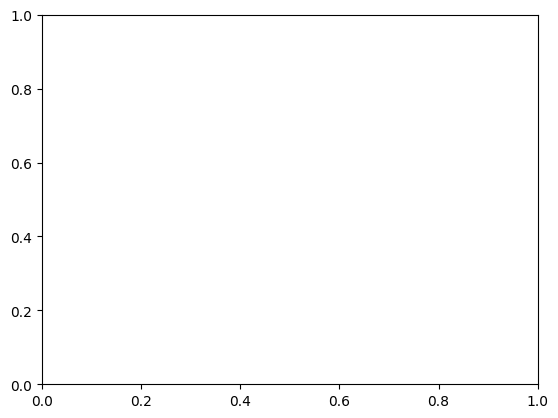

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores.items()}

# Extracting only the values (scores) from the dictionary
scores = list(lh_scores_drop.values())

# Creating a histogram for the scores
plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Creating a histogram for the scores
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Annotating the histogram with the number of values in each bin
for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

# Setting x-axis ticks at intervals of 10 from 0 to 100
plt.xticks(range(-100, 0, 10))

# Adding labels and title for clarity
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
# plt.title('Distribution of Attention Head Performance Drop Percentages')

# Displaying the plot
# plt.show()

# Save the figure
pdf_filename = 'lh_scores_distribution.pdf'
plt.savefig(pdf_filename)

# Download the file in Colab
files.download(pdf_filename)

In [ ]:
import statistics

# Assuming lh_scores_drop is already defined
# For example, lh_scores_drop = {key: max(0, 100 - val) for key, val in lh_scores.items()}

# Extracting the values from the dictionary
scores = list(lh_scores_drop.values())

# Calculating the mean
mean_score = statistics.mean(scores)

print("Mean of the scores:", mean_score)


Mean of the scores: -3.4924875034226313


In [ ]:
# def get_probability_ranking(value, distribution):
#     # Convert distribution to a probability distribution (if not already)
#     total = sum(distribution)
#     prob_distribution = [x / total for x in distribution]

#     # Sort the probability distribution
#     sorted_distribution = sorted(prob_distribution)

#     # Calculate the cumulative probability up to the given value
#     cumulative_prob = sum(prob for prob in sorted_distribution if prob <= value)

#     return cumulative_prob

# # Example usage
# distribution = lh_scores_drop.values()
# value = -0.69  # Value to get the probability ranking for
# ranking = get_probability_ranking(value, distribution)
# print(f"Probability Ranking of {value} in the distribution: {ranking}")


In [ ]:
import pickle

# Saving the dictionary to a file using pickle
with open('nw_lh_scores.pkl', 'wb') as file:
    pickle.dump(lh_scores, file)

from google.colab import files

# Download the file to your local machine
files.download('nw_lh_scores.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# MLP ablation fns

In [26]:
from torch import Tensor
from typing import Dict, Tuple, List
from jaxtyping import Float, Bool
import torch as t

def logits_to_ave_logit_diff(logits: Float[Tensor, "batch seq d_vocab"], dataset: Dataset, per_prompt=False):
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''

    # Only the final logits are relevant for the answer
    # Get the logits corresponding to the indirect object / subject tokens respectively
    corr_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset.word_idx["end"], dataset.corr_tokenIDs]
    incorr_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset.word_idx["end"], dataset.incorr_tokenIDs]
    # Find logit difference
    answer_logit_diff = corr_logits - incorr_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()

In [27]:
def compute_means_by_template_MLP(
    means_dataset: Dataset,
    model: HookedTransformer
) -> Float[Tensor, "layer batch seq head_idx d_head"]:
    '''
    Returns the mean of each head's output over the means dataset. This mean is
    computed separately for each group of prompts with the same template (these
    are given by means_dataset.groups).
    '''
    # Cache the outputs of every head
    _, means_cache = model.run_with_cache(
        means_dataset.toks.long(),
        return_type=None,
        names_filter=lambda name: name.endswith("mlp_out"),
    )
    # Create tensor to store means
    n_layers, d_model = model.cfg.n_layers, model.cfg.d_model
    batch, seq_len = len(means_dataset), means_dataset.max_len
    means = t.zeros(size=(n_layers, batch, seq_len, d_model), device=model.cfg.device)

    # Get set of different templates for this data
    for layer in range(n_layers):
        mlp_output_for_this_layer: Float[Tensor, "batch seq d_model"] = means_cache[utils.get_act_name("mlp_out", layer)]
        for template_group in means_dataset.groups:  # here, we only have one group
            mlp_output_for_this_template = mlp_output_for_this_layer[template_group]
            # aggregate all batches
            mlp_output_means_for_this_template = einops.reduce(mlp_output_for_this_template, "batch seq d_model -> seq d_model", "mean")
            means[layer, template_group] = mlp_output_means_for_this_template
            # at layer, each batch ind is tempalte group (a tensor of size seq d_model)
            # is assigned the SAME mean, "mlp_output_means_for_this_template"

    del(means_cache)

    return means

In [28]:
def get_mlp_outputs_and_posns_to_keep(
    means_dataset: Dataset,
    model: HookedTransformer,
    circuit: Dict[str, List[int]],  # Adjusted to hold list of layers instead of (layer, head) tuples
    seq_pos_to_keep: Dict[str, str],
) -> Dict[int, Bool[Tensor, "batch seq"]]:  # Adjusted the return type to "batch seq"
    '''
    Returns a dictionary mapping layers to a boolean mask giving the indices of the
    MLP output which *shouldn't* be mean-ablated.

    The output of this function will be used for the hook function that does ablation.
    '''
    mlp_outputs_and_posns_to_keep = {}
    batch, seq = len(means_dataset), means_dataset.max_len

    for layer in range(model.cfg.n_layers):
        mask = t.zeros(size=(batch, seq))

        for (mlp_type, layer_list) in circuit.items():
            seq_pos = seq_pos_to_keep[mlp_type]
            indices = means_dataset.word_idx[seq_pos]
            if layer in layer_list:  # Check if the current layer is in the layer list for this mlp_type
                mask[:, indices] = 1

        mlp_outputs_and_posns_to_keep[layer] = mask.bool()

    return mlp_outputs_and_posns_to_keep

In [29]:
def hook_fn_mask_mlp_out(
    mlp_out: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint,
    mlp_outputs_and_posns_to_keep: Dict[int, Bool[Tensor, "batch seq"]],
    means: Float[Tensor, "layer batch seq d_mlp"],
) -> Float[Tensor, "batch seq d_mlp"]:
    '''
    Hook function which masks the MLP output of a transformer layer.

    mlp_outputs_and_posns_to_keep
        Dict created with the get_mlp_outputs_and_posns_to_keep function. This tells
        us where to mask.

    means
        Tensor of mean MLP output values of the means_dataset over each group of prompts
        with the same template. This tells us what values to mask with.
    '''
    # Get the mask for this layer, adapted for MLP output structure
    mask_for_this_layer = mlp_outputs_and_posns_to_keep[hook.layer()].unsqueeze(-1).to(mlp_out.device)

    # Set MLP output values to the mean where necessary
    mlp_out = t.where(mask_for_this_layer, mlp_out, means[hook.layer()])

    return mlp_out

In [30]:
CIRCUIT = {}
SEQ_POS_TO_KEEP = {}
def add_mean_ablation_hook_MLP(
    model: HookedTransformer,
    means_dataset: Dataset,
    circuit: Dict[str, List[Tuple[int, int]]] = CIRCUIT,
    seq_pos_to_keep: Dict[str, str] = SEQ_POS_TO_KEEP,
    is_permanent: bool = True,
) -> HookedTransformer:
    '''
    Adds a permanent hook to the model, which ablates according to the circuit and
    seq_pos_to_keep dictionaries.

    In other words, when the model is run on ioi_dataset, every head's output will
    be replaced with the mean over means_dataset for sequences with the same template,
    except for a subset of heads and sequence positions as specified by the circuit
    and seq_pos_to_keep dicts.
    '''

    model.reset_hooks(including_permanent=True)

    # Compute the mean of each head's output on the ABC dataset, grouped by template
    means = compute_means_by_template_MLP(means_dataset, model)

    # Convert this into a boolean map
    mlp_outputs_and_posns_to_keep = get_mlp_outputs_and_posns_to_keep(means_dataset, model, circuit, seq_pos_to_keep)

    # Get a hook function which will patch in the mean z values for each head, at
    # all positions which aren't important for the circuit
    hook_fn = partial(
        hook_fn_mask_mlp_out,
        mlp_outputs_and_posns_to_keep=mlp_outputs_and_posns_to_keep,
        means=means
    )

    # Apply hook
    model.add_hook(lambda name: name.endswith("mlp_out"), hook_fn, is_permanent=True)

    return model

In [31]:
def mean_ablate_by_lst_MLP(lst, model, orig_score, print_output=True):
    CIRCUIT = {}
    SEQ_POS_TO_KEEP = {}
    for i in range(len(model.tokenizer.tokenize(prompts_list_2[0]['text']))):
        CIRCUIT['S'+str(i)] = lst
        if i == len(model.tokenizer.tokenize(prompts_list_2[0]['text'])) - 1:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
        else:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)

    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    # ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

    model = add_mean_ablation_hook_MLP(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    new_logits = model(dataset.toks)

    # orig_score = logits_to_ave_logit_diff_2(ioi_logits_original, dataset)
    new_score = logits_to_ave_logit_diff(new_logits, dataset)
    del(new_logits)
    if print_output:
        # print(f"Average logit difference (IOI dataset, using entire model): {orig_score:.4f}")
        # print(f"Average logit difference (IOI dataset, only using circuit): {new_score:.4f}")
        print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
    # return new_score
    return 100 * new_score / orig_score

# loop thru MLPs from full

In [ ]:
for i in range(12):
    lst = [layer for layer in range(12) if layer != i]
    perc_of_orig = mean_ablate_by_lst_MLP(lst, model, orig_score, print_output=False).item()
    print(i, perc_of_orig)

0 4.0249505043029785
1 65.28792572021484
2 79.81611633300781
3 81.80935668945312
4 50.76289749145508
5 74.83795166015625
6 66.5409164428711
7 70.29489135742188
8 56.82688522338867
9 15.896557807922363
10 57.913150787353516
11 75.0255355834961


# MLP and Head together fns

## head fns

In [32]:
def get_heads_and_posns_to_keep(
    means_dataset: Dataset,
    model: HookedTransformer,
    circuit: Dict[str, List[Tuple[int, int]]],
    seq_pos_to_keep: Dict[str, str],
) -> Dict[int, Bool[Tensor, "batch seq head"]]:
    '''
    Returns a dictionary mapping layers to a boolean mask giving the indices of the
    z output which *shouldn't* be mean-ablated.

    The output of this function will be used for the hook function that does ablation.
    '''
    heads_and_posns_to_keep = {}
    batch, seq, n_heads = len(means_dataset), means_dataset.max_len, model.cfg.n_heads

    for layer in range(model.cfg.n_layers):

        mask = t.zeros(size=(batch, seq, n_heads))

        for (head_type, head_list) in circuit.items():
            seq_pos = seq_pos_to_keep[head_type]
            indices = means_dataset.word_idx[seq_pos] # modify this for key vs query pos. curr, this is query
            for (layer_idx, head_idx) in head_list:
                if layer_idx == layer:
                    mask[:, indices, head_idx] = 1

        heads_and_posns_to_keep[layer] = mask.bool()

    return heads_and_posns_to_keep

def hook_fn_mask_z(
    z: Float[Tensor, "batch seq head d_head"],
    hook: HookPoint,
    heads_and_posns_to_keep: Dict[int, Bool[Tensor, "batch seq head"]],
    means: Float[Tensor, "layer batch seq head d_head"],
) -> Float[Tensor, "batch seq head d_head"]:
    '''
    Hook function which masks the z output of a transformer head.

    heads_and_posns_to_keep
        Dict created with the get_heads_and_posns_to_keep function. This tells
        us where to mask.

    means
        Tensor of mean z values of the means_dataset over each group of prompts
        with the same template. This tells us what values to mask with.
    '''
    # Get the mask for this layer, and add d_head=1 dimension so it broadcasts correctly
    mask_for_this_layer = heads_and_posns_to_keep[hook.layer()].unsqueeze(-1).to(z.device)

    # Set z values to the mean
    z = t.where(mask_for_this_layer, z, means[hook.layer()])

    return z

def compute_means_by_template(
    means_dataset: Dataset,
    model: HookedTransformer
) -> Float[Tensor, "layer batch seq head_idx d_head"]:
    '''
    Returns the mean of each head's output over the means dataset. This mean is
    computed separately for each group of prompts with the same template (these
    are given by means_dataset.groups).
    '''
    # Cache the outputs of every head
    _, means_cache = model.run_with_cache(
        means_dataset.toks.long(),
        return_type=None,
        names_filter=lambda name: name.endswith("z"),
    )
    # Create tensor to store means
    n_layers, n_heads, d_head = model.cfg.n_layers, model.cfg.n_heads, model.cfg.d_head
    batch, seq_len = len(means_dataset), means_dataset.max_len
    means = t.zeros(size=(n_layers, batch, seq_len, n_heads, d_head), device=model.cfg.device)

    # Get set of different templates for this data
    for layer in range(model.cfg.n_layers):
        z_for_this_layer: Float[Tensor, "batch seq head d_head"] = means_cache[utils.get_act_name("z", layer)]
        for template_group in means_dataset.groups:
            z_for_this_template = z_for_this_layer[template_group]
            z_means_for_this_template = einops.reduce(z_for_this_template, "batch seq head d_head -> seq head d_head", "mean")
            means[layer, template_group] = z_means_for_this_template

    del(means_cache)

    return means

def add_mean_ablation_hook(
    model: HookedTransformer,
    means_dataset: Dataset,
    circuit: Dict[str, List[Tuple[int, int]]] = CIRCUIT,
    seq_pos_to_keep: Dict[str, str] = SEQ_POS_TO_KEEP,
    is_permanent: bool = True,
) -> HookedTransformer:
    '''
    Adds a permanent hook to the model, which ablates according to the circuit and
    seq_pos_to_keep dictionaries.

    In other words, when the model is run on ioi_dataset, every head's output will
    be replaced with the mean over means_dataset for sequences with the same template,
    except for a subset of heads and sequence positions as specified by the circuit
    and seq_pos_to_keep dicts.
    '''

    model.reset_hooks(including_permanent=True)

    # Compute the mean of each head's output on the ABC dataset, grouped by template
    means = compute_means_by_template(means_dataset, model)

    # Convert this into a boolean map
    heads_and_posns_to_keep = get_heads_and_posns_to_keep(means_dataset, model, circuit, seq_pos_to_keep)

    # Get a hook function which will patch in the mean z values for each head, at
    # all positions which aren't important for the circuit
    hook_fn = partial(
        hook_fn_mask_z,
        heads_and_posns_to_keep=heads_and_posns_to_keep,
        means=means
    )

    # Apply hook
    model.add_hook(lambda name: name.endswith("z"), hook_fn, is_permanent=is_permanent)

    return model

## both

In [33]:
def add_mean_ablation_hook_MLP_head(
    model: HookedTransformer,
    means_dataset: Dataset,
    heads_lst, mlp_lst,
    is_permanent: bool = True,
) -> HookedTransformer:
    CIRCUIT = {}
    SEQ_POS_TO_KEEP = {}
    for i in range(len(model.tokenizer.tokenize(prompts_list_2[0]['text']))):
        CIRCUIT['S'+str(i)] = heads_lst
        if i == len(model.tokenizer.tokenize(prompts_list_2[0]['text'])) - 1:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
        else:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)

    model.reset_hooks(including_permanent=True)

    # Compute the mean of each head's output on the ABC dataset, grouped by template
    means = compute_means_by_template(means_dataset, model)

    # Convert this into a boolean map
    heads_and_posns_to_keep = get_heads_and_posns_to_keep(means_dataset, model, CIRCUIT, SEQ_POS_TO_KEEP)

    # Get a hook function which will patch in the mean z values for each head, at
    # all positions which aren't important for the circuit
    hook_fn = partial(
        hook_fn_mask_z,
        heads_and_posns_to_keep=heads_and_posns_to_keep,
        means=means
    )

    # Apply hook
    model.add_hook(lambda name: name.endswith("z"), hook_fn, is_permanent=is_permanent)

    ########################
    CIRCUIT = {}
    SEQ_POS_TO_KEEP = {}
    for i in range(len(model.tokenizer.tokenize(prompts_list_2[0]['text']))):
        CIRCUIT['S'+str(i)] = mlp_lst
        if i == len(model.tokenizer.tokenize(prompts_list_2[0]['text'])) - 1:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
        else:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)

    # Compute the mean of each head's output on the ABC dataset, grouped by template
    means = compute_means_by_template_MLP(means_dataset, model)

    # Convert this into a boolean map
    mlp_outputs_and_posns_to_keep = get_mlp_outputs_and_posns_to_keep(means_dataset, model, CIRCUIT, SEQ_POS_TO_KEEP)

    # Get a hook function which will patch in the mean z values for each head, at
    # all positions which aren't important for the circuit
    hook_fn = partial(
        hook_fn_mask_mlp_out,
        mlp_outputs_and_posns_to_keep=mlp_outputs_and_posns_to_keep,
        means=means
    )

    # Apply hook
    model.add_hook(lambda name: name.endswith("mlp_out"), hook_fn, is_permanent=True)

    return model

## loop iters

In [34]:
def find_circuit_forw(heads_not_ablate=None, mlps_not_ablate=None, orig_score=100, threshold=10):
    # threshold is T, a %. if performance is less than T%, allow its removal
    # we don't ablate the curr circuits
    if heads_not_ablate == []: # Start with full circuit
        heads_not_ablate = [(layer, head) for layer in range(12) for head in range(12)]
    if mlps_not_ablate == []:
        mlps_not_ablate = [layer for layer in range(12)]

    comp_scores = {}
    for layer in range(0, 12):
        for head in range(12):
            print(layer, head)
            if (layer, head) not in heads_not_ablate:
                continue

            copy_heads_not_ablate = heads_not_ablate.copy()
            copy_heads_not_ablate.remove((layer, head))

            model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
            ablated_model = add_mean_ablation_hook_MLP_head(model, dataset_2, copy_heads_not_ablate, mlps_not_ablate)

            new_logits = ablated_model(dataset.toks)
            new_score = logits_to_ave_logit_diff(new_logits, dataset)
            new_perc = 100 * new_score / orig_score
            comp_scores[layer] = new_perc
            print(f"(cand circuit / full) %: {new_perc:.4f}")
            if (100 - new_perc) < threshold:
                heads_not_ablate.remove((layer, head))
                print("Removed:", (layer, head))
            del(new_logits)

        # print(layer)
        # if layer in mlps_not_ablate:
        #     copy_mlps_not_ablate = mlps_not_ablate.copy()
        #     copy_mlps_not_ablate.remove(layer)

        #     model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
        #     ablated_model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, copy_mlps_not_ablate)

        #     new_logits = ablated_model(dataset.toks)
        #     new_score = logits_to_ave_logit_diff(new_logits, dataset)
        #     new_perc = 100 * new_score / orig_score
        #     comp_scores[(layer, head)] = new_perc
        #     print(f"(cand circuit / full) %: {new_perc:.4f}")
        #     if (100 - new_perc) < threshold:
        #         mlps_not_ablate.remove(layer)
        #         print("Removed: MLP ", layer)
        #     del(new_logits)

    return heads_not_ablate, mlps_not_ablate, new_perc, comp_scores

In [35]:
def find_circuit_backw(heads_not_ablate=None, mlps_not_ablate=None, orig_score=100, threshold=10, iter=1):
    # threshold is T, a %. if performance is less than T%, allow its removal
    # we don't ablate the curr circuits
    if heads_not_ablate == []: # Start with full circuit
        heads_not_ablate = [(layer, head) for layer in range(12) for head in range(12)]
    if mlps_not_ablate == []:
        mlps_not_ablate = [layer for layer in range(12)]

    comp_scores = {}
    for layer in range(11, -1, -1):  # go thru all heads in a layer first
        print(layer)
        if layer in mlps_not_ablate and iter < 2:
            copy_mlps_not_ablate = mlps_not_ablate.copy()
            copy_mlps_not_ablate.remove(layer)

            model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
            ablated_model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, copy_mlps_not_ablate)

            new_logits = ablated_model(dataset.toks)
            new_score = logits_to_ave_logit_diff(new_logits, dataset)
            new_perc = 100 * new_score / orig_score
            comp_scores[layer] = new_perc
            print(f"(cand circuit / full) %: {new_perc:.4f}")
            if (100 - new_perc) < threshold:
                mlps_not_ablate.remove(layer)
                print("Removed: MLP ", layer)
            del(new_logits)

        for head in range(12):
            print(layer, head)
            if (layer, head) not in heads_not_ablate:
                continue

            copy_heads_not_ablate = heads_not_ablate.copy()
            copy_heads_not_ablate.remove((layer, head))

            model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
            ablated_model = add_mean_ablation_hook_MLP_head(model, dataset_2, copy_heads_not_ablate, mlps_not_ablate)

            new_logits = ablated_model(dataset.toks)
            new_score = logits_to_ave_logit_diff(new_logits, dataset)
            new_perc = 100 * new_score / orig_score
            comp_scores[(layer, head)] = new_perc
            print(f"(cand circuit / full) %: {new_perc:.4f}")
            if (100 - new_perc) < threshold:
                heads_not_ablate.remove((layer, head))
                print("Removed:", (layer, head))
            del(new_logits)

    return heads_not_ablate, mlps_not_ablate, new_score, comp_scores

# iter backw fwd, threshold 20

In [ ]:
threshold = 20
curr_circ_heads = []
curr_circ_mlps = []
prev_score = 100
new_score = 0
iter = 1
all_comp_scores = []
while prev_score != new_score:
    print('\nbackw prune, iter ', str(iter))
    # prev_score = new_score # save old score before finding new one
    old_circ_heads = curr_circ_heads.copy() # save old before finding new one
    old_circ_mlps = curr_circ_mlps.copy()
    curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_backw(curr_circ_heads, curr_circ_mlps, orig_score, threshold, iter)
    if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
        break
    all_comp_scores.append(comp_scores)
    print('\nfwd prune, iter ', str(iter))
    # track changes in circuit as for some reason it doesn't work with scores
    old_circ_heads = curr_circ_heads.copy()
    old_circ_mlps = curr_circ_mlps.copy()
    curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_forw(curr_circ_heads, curr_circ_mlps, orig_score, threshold)
    if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
        break
    all_comp_scores.append(comp_scores)
    iter += 1


backw prune, iter  1
11
(cand circuit / full) %: 75.0255
11 0
(cand circuit / full) %: 99.7315
Removed: (11, 0)
11 1
(cand circuit / full) %: 99.8717
Removed: (11, 1)
11 2
(cand circuit / full) %: 99.8522
Removed: (11, 2)
11 3
(cand circuit / full) %: 99.9779
Removed: (11, 3)
11 4
(cand circuit / full) %: 99.5896
Removed: (11, 4)
11 5
(cand circuit / full) %: 99.6130
Removed: (11, 5)
11 6
(cand circuit / full) %: 99.6287
Removed: (11, 6)
11 7
(cand circuit / full) %: 99.5665
Removed: (11, 7)
11 8
(cand circuit / full) %: 99.2456
Removed: (11, 8)
11 9
(cand circuit / full) %: 98.4471
Removed: (11, 9)
11 10
(cand circuit / full) %: 97.2846
Removed: (11, 10)
11 11
(cand circuit / full) %: 97.5267
Removed: (11, 11)
10
(cand circuit / full) %: 55.1619
10 0
(cand circuit / full) %: 97.5296
Removed: (10, 0)
10 1
(cand circuit / full) %: 96.6200
Removed: (10, 1)
10 2
(cand circuit / full) %: 103.0986
Removed: (10, 2)
10 3
(cand circuit / full) %: 103.1752
Removed: (10, 3)
10 4
(cand circuit /

In [ ]:
import pickle
from google.colab import files

with open('nw_bf_20_scores.pkl', 'wb') as file:
    pickle.dump(all_comp_scores, file)
files.download('nw_bf_20_scores.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
curr_circ_heads

[(0, 1),
 (1, 5),
 (4, 4),
 (4, 10),
 (5, 8),
 (6, 1),
 (6, 6),
 (6, 10),
 (7, 2),
 (7, 6),
 (7, 11),
 (8, 1),
 (8, 6),
 (8, 8),
 (8, 9),
 (8, 11),
 (9, 1),
 (9, 5),
 (9, 7)]

In [ ]:
curr_circ_mlps

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

## loop rmv and check for most impt heads

In [ ]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_mean_ablation_hook_MLP_head(model, dataset_2, curr_circ_heads, curr_circ_mlps)

new_logits = model(dataset.toks)
new_score = logits_to_ave_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

# len(curr_circ_heads)
# len(curr_circ_mlps)

(cand circuit / full) %: 81.1096


In [ ]:
lh_scores = {}
for lh in curr_circ_heads:
    copy_circuit = curr_circ_heads.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
    model = add_mean_ablation_hook_MLP_head(model, dataset_2, copy_circuit, curr_circ_mlps)

    new_logits = model(dataset.toks)
    new_score = logits_to_ave_logit_diff(new_logits, dataset).item()
    new_perc = 100 * new_score / orig_score
    print(f"(cand circuit / full) %: {new_perc:.4f}")
    lh_scores[lh] = new_perc

removed: (0, 1)
(cand circuit / full) %: 2.3691
removed: (1, 5)
(cand circuit / full) %: 62.4586
removed: (4, 4)
(cand circuit / full) %: 46.9987
removed: (4, 10)
(cand circuit / full) %: 75.3836
removed: (5, 8)
(cand circuit / full) %: 75.9623
removed: (6, 1)
(cand circuit / full) %: 76.6214
removed: (6, 6)
(cand circuit / full) %: 71.4101
removed: (6, 10)
(cand circuit / full) %: 56.8324
removed: (7, 2)
(cand circuit / full) %: 78.2655
removed: (7, 6)
(cand circuit / full) %: 76.1487
removed: (7, 11)
(cand circuit / full) %: 36.3295
removed: (8, 1)
(cand circuit / full) %: 68.5016
removed: (8, 6)
(cand circuit / full) %: 74.8917
removed: (8, 8)
(cand circuit / full) %: 67.9027
removed: (8, 9)
(cand circuit / full) %: 77.7477
removed: (8, 11)
(cand circuit / full) %: 70.2452
removed: (9, 1)
(cand circuit / full) %: 53.3702
removed: (9, 5)
(cand circuit / full) %: 75.2664
removed: (9, 7)
(cand circuit / full) %: 78.0327


In [ ]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
sorted_lh_scores

{(0, 1): tensor(2.3691, device='cuda:0'),
 (7, 11): tensor(36.3295, device='cuda:0'),
 (4, 4): tensor(46.9987, device='cuda:0'),
 (9, 1): tensor(53.3702, device='cuda:0'),
 (6, 10): tensor(56.8324, device='cuda:0'),
 (1, 5): tensor(62.4586, device='cuda:0'),
 (8, 8): tensor(67.9027, device='cuda:0'),
 (8, 1): tensor(68.5016, device='cuda:0'),
 (8, 11): tensor(70.2452, device='cuda:0'),
 (6, 6): tensor(71.4101, device='cuda:0'),
 (8, 6): tensor(74.8917, device='cuda:0'),
 (9, 5): tensor(75.2664, device='cuda:0'),
 (4, 10): tensor(75.3836, device='cuda:0'),
 (5, 8): tensor(75.9623, device='cuda:0'),
 (7, 6): tensor(76.1487, device='cuda:0'),
 (6, 1): tensor(76.6214, device='cuda:0'),
 (8, 9): tensor(77.7477, device='cuda:0'),
 (9, 7): tensor(78.0327, device='cuda:0'),
 (7, 2): tensor(78.2655, device='cuda:0')}

In [ ]:
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score.item(), 2))

(0, 1) -78.74
(7, 11) -44.78
(4, 4) -34.11
(9, 1) -27.74
(6, 10) -24.28
(1, 5) -18.65
(8, 8) -13.21
(8, 1) -12.61
(8, 11) -10.86
(6, 6) -9.7
(8, 6) -6.22
(9, 5) -5.84
(4, 10) -5.73
(5, 8) -5.15
(7, 6) -4.96
(6, 1) -4.49
(8, 9) -3.36
(9, 7) -3.08
(7, 2) -2.84


# try other tasks circs, thres 20

In [36]:
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 0), (6, 1), (6, 6), (6, 10), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (9, 1)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = logits_to_ave_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 48.4090


In [37]:
# numwords
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 8), (6, 1), (6, 6), (6, 10), (7, 2), (7, 6), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (8, 11), (9, 1), (9, 5), (9, 7)]
mlps_not_ablate = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = logits_to_ave_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 81.1096


In [38]:
# months
heads_not_ablate = [(0, 1), (0, 5), (4, 4), (6, 1), (6, 6), (6, 10), (7, 6), (7, 9), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = logits_to_ave_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 32.3630


In [45]:
CIRCUIT = {
    "name mover": [(9, 9), (10, 0), (9, 6)],
    "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    "negative name mover": [(10, 7), (11, 10)],
    "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    "duplicate token": [(0, 1), (0, 10), (3, 0)],
    "previous token": [(2, 2), (4, 11)],
}

import itertools
a = [val for val in CIRCUIT.values()]
IOI_heads = list(itertools.chain.from_iterable(a))

mlps_not_ablate = list(range(12))

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_mean_ablation_hook_MLP_head(model, dataset_2, IOI_heads, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = logits_to_ave_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: -15.8257


In [46]:
IOI_heads

[(9, 9),
 (10, 0),
 (9, 6),
 (10, 10),
 (10, 6),
 (10, 2),
 (10, 1),
 (11, 2),
 (9, 7),
 (9, 0),
 (11, 9),
 (10, 7),
 (11, 10),
 (7, 3),
 (7, 9),
 (8, 6),
 (8, 10),
 (5, 5),
 (5, 8),
 (5, 9),
 (6, 9),
 (0, 1),
 (0, 10),
 (3, 0),
 (2, 2),
 (4, 11)]